In [1]:
import math, random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [2]:
data = [ torch.randint(1, 63, (random.randint(12, 24),)) for _ in range(8) ]
length = [ t.shape[0] for t in data]
data, length

([tensor([16, 57, 36, 32, 44, 17, 55, 30, 62, 55, 19, 56, 61,  1, 38, 61, 33, 20,
          48, 60, 37, 33, 50, 24]),
  tensor([47, 31, 20, 21, 50, 10, 50, 42, 59, 38, 56, 15, 16, 43, 26]),
  tensor([36, 62, 36, 33, 38, 11, 43, 51, 35, 61, 41, 10, 51, 32, 31, 49,  7, 40,
          31,  8, 24, 13, 39,  3]),
  tensor([24, 27, 61,  8, 22, 18, 24, 22, 34, 11, 17, 56, 20, 20, 39, 35, 23, 30,
          60]),
  tensor([47,  9,  2, 23,  6, 33, 13, 15, 31, 57, 42, 40, 41, 47]),
  tensor([58, 18, 56, 59,  9, 33, 52, 42, 26, 41, 49, 47, 36, 40, 51, 53, 47, 32,
          32]),
  tensor([36, 23, 37,  8, 24, 45, 15, 62, 13, 28, 10, 28,  1, 55, 61, 52, 61, 41,
          10]),
  tensor([61,  6, 28, 17, 52, 44, 48, 17,  2,  5, 10, 45, 21, 13, 15, 21,  6, 48,
          26])],
 [24, 15, 24, 19, 14, 19, 19, 19])

In [3]:
X_batch = pad_sequence(data, True)
X_batch, length

(tensor([[16, 57, 36, 32, 44, 17, 55, 30, 62, 55, 19, 56, 61,  1, 38, 61, 33, 20,
          48, 60, 37, 33, 50, 24],
         [47, 31, 20, 21, 50, 10, 50, 42, 59, 38, 56, 15, 16, 43, 26,  0,  0,  0,
           0,  0,  0,  0,  0,  0],
         [36, 62, 36, 33, 38, 11, 43, 51, 35, 61, 41, 10, 51, 32, 31, 49,  7, 40,
          31,  8, 24, 13, 39,  3],
         [24, 27, 61,  8, 22, 18, 24, 22, 34, 11, 17, 56, 20, 20, 39, 35, 23, 30,
          60,  0,  0,  0,  0,  0],
         [47,  9,  2, 23,  6, 33, 13, 15, 31, 57, 42, 40, 41, 47,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0],
         [58, 18, 56, 59,  9, 33, 52, 42, 26, 41, 49, 47, 36, 40, 51, 53, 47, 32,
          32,  0,  0,  0,  0,  0],
         [36, 23, 37,  8, 24, 45, 15, 62, 13, 28, 10, 28,  1, 55, 61, 52, 61, 41,
          10,  0,  0,  0,  0,  0],
         [61,  6, 28, 17, 52, 44, 48, 17,  2,  5, 10, 45, 21, 13, 15, 21,  6, 48,
          26,  0,  0,  0,  0,  0]]),
 [24, 15, 24, 19, 14, 19, 19, 19])

In [489]:
def create_sin_cos_encoding(d_model, max_seq_length, dtype, device):
  kargs = {
    'dtype': dtype,
    'device': device
  }
  pe = torch.zeros(max_seq_length, d_model, **kargs)
  position = torch.arange(0, max_seq_length, **kargs).unsqueeze(1)
  div_term = torch.exp(torch.arange(0, d_model, 2, **kargs).float() * -(math.log(1e+4) / d_model))

  pe[:, 0::2] = torch.sin(position * div_term)
  pe[:, 1::2] = torch.cos(position * div_term)

  return pe.unsqueeze(0)

class PositionalEncoding(nn.Module):
  def __init__(self, d_model=512, max_seq_length=2048, dtype=None, device=None):
    super(PositionalEncoding, self).__init__()
    self.d_model = d_model
    self.max_seq_length = max_seq_length
    pe = create_sin_cos_encoding(d_model, max_seq_length, dtype, device)
    
    self.register_buffer('pe', pe)
  
  def forward(self, X):
    return X + self.pe[:, :X.shape[1]].to(X.device)

  def __repr__(self):
    return f'{PositionalEncoding.__name__}(d_model={self.d_model}, max={self.max_seq_length})'

class StepEncoding(nn.Module):
  def __init__(self, d_model=512, max_seq_length=2048, dtype=None, device=None):
    super(StepEncoding, self).__init__()
    self.d_model = d_model
    self.max_seq_length = max_seq_length
    pe = create_sin_cos_encoding(d_model, max_seq_length, dtype, device)
    
    self.register_buffer('pe', pe)
  
  def forward(self, X, steps, mask=None):
    if mask is None:
      return X + self.pe[0][steps,:].unsqueeze(1)
    else:
      steps_per_mask = (mask * steps.unsqueeze(1))[mask]
      X[mask] += self.pe[0][steps_per_mask]
      return X

  def __repr__(self):
    return f'{StepEncoding.__name__}(d_model={self.d_model}, max={self.max_seq_length})'


In [484]:
pe = StepEncoding(6, 16, dtype=torch.float16)
data = torch.zeros(2, 4, 6, dtype=torch.float16)
mask = torch.BoolTensor([
  [0, 0, 1, 1],
  [0, 1, 1, 1]
])
steps = torch.LongTensor([5, 3])

out_data = pe(data, steps, mask)

In [490]:
class MaskedForwardDiffusion(nn.Module):
  def __init__(self, max_steps, dtype=None, device=None):
    self.kargs = {
      'dtype': dtype,
      'device': device
    }
    super(MaskedForwardDiffusion, self).__init__()
    self.max_steps = max_steps

  def forward(self, X, steps, mask):
    noise = torch.randn_like(X, **self.kargs)

    noise_intense = 1.0 - (steps / self.max_steps).unsqueeze(-1)
    noise_intense = 1.0 - torch.cos(torch.pi * noise_intense / 2)

    X[mask] *= (mask * noise_intense)[mask].unsqueeze(-1)
    X[mask] += noise[mask] * (mask * (1.0-noise_intense))[mask].unsqueeze(-1)

    return X

  def __repr__(self):
    return f"{MaskedForwardDiffusion.__name__}(steps={self.max_steps})"

MaskedForwardDiffusion(64)

MaskedForwardDiffusion(steps=64)

In [516]:
class EmbeddingBlockFirst(nn.Module):
  def __init__(self, vocab_size, d_model, pad_idx, max_steps, dtype=None, device=None):
    kargs = { 'dtype': dtype, 'device': device }
    super(EmbeddingBlockFirst, self).__init__()
    self.word_embedding = nn.Embedding(vocab_size, d_model, pad_idx, **kargs)
    self.masked_forward_diffusion = MaskedForwardDiffusion(max_steps, **kargs)

  def forward(self, X, steps, mask):
    embed = self.word_embedding(X)
    embed_diff = self.masked_forward_diffusion.forward(embed, steps, mask)
    return embed_diff

class EmbeddingBlockSecond(nn.Module):
  def __init__(self, d_model, max_steps, dropout=0.1, dtype=None, device=None):
    kargs = { 'dtype': dtype, 'device': device }
    super(EmbeddingBlockSecond, self).__init__()
    self.pe = PositionalEncoding(d_model, 512, **kargs)
    self.se = StepEncoding(d_model, max_steps, **kargs)
    self.norm = nn.LayerNorm(d_model, **kargs)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, X, steps, mask):
    X_pe = self.pe(X)
    X_se = self.se(X_pe, steps, mask)
    norm = self.norm(X_se)
    out = self.dropout(norm)
    return out

class EmbeddingBlock(nn.Module):
  def __init__(self, vocab_size, d_model, pad_idx, max_steps, dropout=0.1, dtype=None, device=None):
    kargs = { 'dtype': dtype, 'device': device }
    super(EmbeddingBlock, self).__init__()
    self.first = EmbeddingBlockFirst(vocab_size, d_model, pad_idx, max_steps, **kargs)
    self.second = EmbeddingBlockSecond(d_model, max_steps, dropout, **kargs)
  
  def forward(self, X, steps, mask):
    X_first = self.first(X, steps, mask)
    X_second = self.second(X_first, steps, mask)
    return X_second

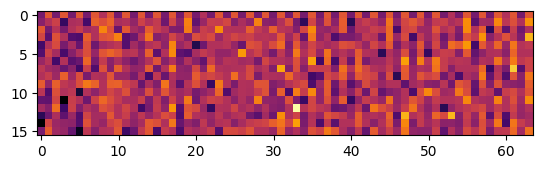

In [524]:
max_steps = 64
d_model = 64

embedding = EmbeddingBlock(128, d_model, 0, max_steps)

data = torch.randint(0, 127, (2, 8))
steps = torch.randint(60, 63, (2,))
mask = torch.BoolTensor([
  [0, 0, 0, 1, 1, 1, 1, 1],
  [0, 0, 0, 0, 0, 1, 1, 1]
])

data = embedding(data, steps, mask)

plt.imshow(data.reshape(-1, data.shape[-1]).detach().numpy(), cmap='inferno')

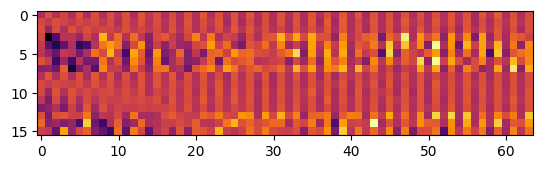

In [480]:
max_steps = 64
d_model = 64

mdf = MaskedForwardDiffusion(max_steps)
se = StepEncoding(d_model, 64)
pe = PositionalEncoding(d_model, 64)

data = torch.randn(2, 8, d_model) * 1e-1
steps = torch.randint(0, 63, (2,))
mask = torch.BoolTensor([
  [0, 0, 0, 1, 1, 1, 1, 1],
  [0, 0, 0, 0, 0, 1, 1, 1]
])

data = mdf(data, steps, mask)
data = se(data, steps, mask)
data = pe(data)

plt.imshow(data.reshape(-1, data.shape[-1]).detach().numpy(), cmap='inferno')

In [532]:
class EncoderTransformer(nn.Module):
  def __init__(self, d_model, nheads, dropout=0.1, dim_feedforward=2048, activation=F.gelu, device=None, dtype=None):
    factory_kwargs = { 'device': device, 'dtype': dtype }
    super(EncoderTransformer, self).__init__()
    
    self.self_attn = nn.MultiheadAttention(d_model, nheads, dropout, False, batch_first=True, **factory_kwargs)
    self.dropout1 = nn.Dropout(dropout)
    self.norm1 = nn.LayerNorm(d_model, **factory_kwargs)

    self.linear1 = nn.Linear(d_model, dim_feedforward, **factory_kwargs)
    self.dropout = nn.Dropout(dropout)
    self.linear2 = nn.Linear(dim_feedforward, d_model, **factory_kwargs)
    self.dropout2 = nn.Dropout(dropout)

    self.norm2 = nn.LayerNorm(d_model, **factory_kwargs)

    self.activation = activation
  
  def _sa_block(self, x, attn_mask, padding_mask) -> torch.Tensor:
    x, _ = self.self_attn(x, x, x, attn_mask=attn_mask, key_padding_mask=padding_mask, need_weights=False)
    return self.dropout1(x)

  def _ff_block(self, x) -> torch.Tensor:
    x = self.linear2(self.dropout(self.activation(self.linear1(x))))
    return self.dropout2(x)

  def forward(self, src, attn_mask=None, padding_mask=None):
    x = src
    x = self.norm1(x + self._sa_block(x, attn_mask, padding_mask))
    x = self.norm2(x + self._ff_block(x))
    return x

class Classification(nn.Module):
  def __init__(self, d_model, vocab_size, dropout=0.1, dim_feedforward=2048, activation=F.gelu, device=None, dtype=None):
    factory_kwargs = { 'device': device, 'dtype': dtype }
    super(Classification, self).__init__()

    self.linear = nn.Linear(d_model, dim_feedforward, **factory_kwargs)
    self.dropout = nn.Dropout(dropout)
    self.activation = activation
    self.linear_out = nn.Linear(dim_feedforward, vocab_size, **factory_kwargs)

  def forward(self, X):
    X = self.activation(self.dropout(self.linear(X)))
    return self.linear_out(X)
  
class Model(nn.Module):
  def __init__(self, vocab_size, d_model, nheads, num_layers, dropout=0.1, activation=F.gelu, device=None, dtype=None):
    factory_kwargs = { 'device': device, 'dtype': dtype }
    super(Model, self).__init__()
    encoder_layer = EncoderTransformer(d_model, nheads, dropout, activation=activation, **factory_kwargs)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
    self.classification = Classification(d_model, vocab_size, dropout, activation=activation, **factory_kwargs)
  

Model(256, 32, 4, 8)

Model(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x EncoderTransformer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=False)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (classification): Classification(
    (linear): Linear(in_features=32, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear_out): Linear(in_features=2048, out_features=256, bias=True)
  )
)